In [133]:
import time
from tqdm import tqdm

import torch
import s3prl
import torchaudio
import torch.nn.functional as F
from torchaudio.models import Emformer
import numpy as np

import matplotlib.pyplot as plt
import scipy

import wav2avatar.streaming.hifigan.wav_ema_dataset as wav_ema_dataset
import wav2avatar.streaming.hifigan.collate as collate
from wav2avatar.inversion.linear_inversion import LinearInversion
from wav2avatar.streaming.emformer.emformer import EMAEmformer

from importlib import reload
import wav2avatar.inversion.linear_inversion
reload(wav2avatar.inversion.linear_inversion)
reload(wav_ema_dataset)
from wav2avatar.inversion.linear_inversion import EMADataset

In [2]:
class EMAEmformer(torch.nn.Module):

    def __init__(
        self,
        input_dim=512,
        num_heads=8,
        ffn_dim=256,
        num_layers=15,
        segment_length=5,
        left_context_length=45
    ):
        super().__init__()

        self.emformer = Emformer(
            input_dim=input_dim,
            num_heads=num_heads,
            ffn_dim=ffn_dim,
            num_layers=num_layers,
            segment_length=segment_length,
            left_context_length=left_context_length
        )

        self.output_layer = torch.nn.Linear(512, 12)
    
    def forward(self, x, lengths=None):
        x, lengths = self.emformer(x, lengths)
        x = self.output_layer(x)
        x = x.transpose(2, 1)
        return x
    
    def infer(self, x, lengths, state):
        x, lengths, state = self.emformer.infer(x, lengths, state)
        x = self.output_layer(x)
        x = x.transpose(2, 1)
        return x, state

In [95]:
device = 7

input_dim=512
num_heads=16
ffn_dim=512
num_layers=15
segment_length=5
left_context_length=20
right_context_length=0

emformer = EMAEmformer(
    input_dim=input_dim,
    num_heads=num_heads,
    ffn_dim=ffn_dim,
    num_layers=num_layers,
    segment_length=segment_length,
    left_context_length=left_context_length
).to(device)

ckpt = torch.load(f"../emformer/ckpts/emf_l{left_context_length}_r{right_context_length}_p{segment_length}_nh{num_heads}__nl{num_layers}_ffd{ffn_dim}_0.89.pth")

emformer.load_state_dict(ckpt["emformer_state_dict"])

input_tens = torch.zeros(56, 50, 512).to(device)
lengths = torch.zeros(56,) + 5
lengths = lengths.to(device)

emformer(input_tens, lengths).shape

torch.Size([56, 12, 50])

In [87]:
dataset = wav_ema_dataset.WavEMADataset(device=7)

Loading files from directories...


In [88]:
train_amt = int(len(dataset) * 0.9)
test_amt = len(dataset) - train_amt
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_amt, test_amt])
dataloader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=1, 
    shuffle=True)

In [66]:
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=1, 
    shuffle=True)

In [67]:
batch = next(iter(test_dataloader))

In [52]:
batch[0].squeeze(0).shape, batch[1].squeeze(0).shape

(torch.Size([1, 512, 115]), torch.Size([1, 12, 127]))

In [9]:
def train_emformer_step(batch):
    x = batch[0].to(device).squeeze(0)
    y = batch[1].to(device).squeeze(0)

    x = x.transpose(1, 2)
    lengths = torch.zeros(x.shape[0],) + 5
    lengths = lengths.to(device)
    y_hat = emformer(x, lengths)
    loss = F.l1_loss(y_hat, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    return loss

In [10]:
optimizer = torch.optim.Adam(emformer.parameters(), lr=1e-4, betas=[0.5, 0.9], weight_decay=0.0)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, gamma=0.5, milestones=[40000, 80000, 120000, 160000])

In [ ]:
step = 0
eval_step = 10000

# (1) (2) Get batch
data_tqdm = tqdm(dataloader)
loss = torch.tensor([999])

losses = []

#test_batch = next(iter(test_dataloader))

best_corr = 0

for batch in data_tqdm:
    data_tqdm.set_description(f"Training step {step}")

    loss = train_emformer_step(batch)
    losses.append(loss.item())

    if step % eval_step == 0:
        print("Correlation:", eval_enformer())
    #    pred_ema, true_ema, corr = eval_gen(test_batch, step_size=5)
    #    #corr = correlations(pred_ema, true_ema)
    #    #print(f"Correlations: {round(corr, 2)}")
    #    feat_num = 0
    #    plt.plot(true_ema[:300, feat_num], label="target")
    #    plt.plot(pred_ema[:300, feat_num], label="pred")
    #    plt.legend()
    #    plt.show()

    #    if corr > best_corr:
    #        save_ckpt(corr)
    #        best_corr = corr

    data_tqdm.set_postfix(loss=loss.item())
    step += 1

In [24]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(emformer)

19755276

In [106]:
test_audio = test_batch[0].transpose(1, 2).to(device)[:, :5, :]
test_ema = test_batch[1].to(device)[:, :, :5]
print(test_audio.shape, test_ema.shape)

torch.Size([283, 5, 512]) torch.Size([283, 12, 5])


In [92]:
lengths = torch.zeros(test_audio.shape[0],) + 50
lengths = lengths.to(device)
#emformer.infer(test_audio.to(device), lengths.to(device))
x, lengths, state = emformer.emformer.infer(test_audio, lengths)
x = emformer.output_layer(x)
x = x.transpose(2, 1)

In [107]:
x = x.reshape(-1, 12)
test_ema = test_ema.reshape(-1, 12)
print(x.shape, test_ema.shape)

torch.Size([1415, 12]) torch.Size([1415, 12])


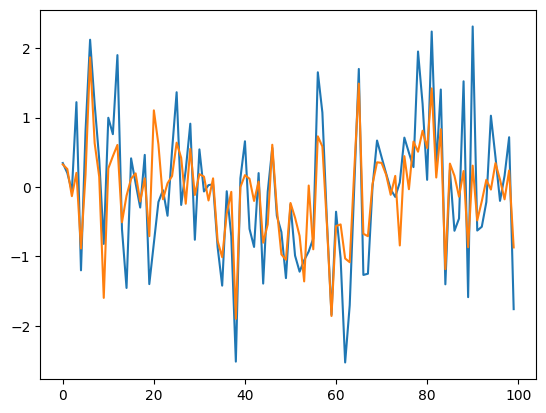

In [111]:
plt.plot(test_ema[:100, 0].detach().cpu())
plt.plot(x[:100, 0].detach().cpu())

In [115]:
scipy.stats.pearsonr(x[:, 2].detach().cpu(), test_ema[:, 2].detach().cpu())

PearsonRResult(statistic=0.7415266942482053, pvalue=3.5095019421308146e-247)

In [10]:
feature_model = getattr(s3prl.hub, "wavlm_large")()
feature_model = feature_model.model.feature_extractor.to(device)

In [11]:
mng_08_audio, sr = torchaudio.load("../../inversion/wav/mngu0_s1_0008.wav")
mng_ema_gt = np.load("../../inversion/ema/mngu0_s1_0008.npy")
def mngu0_to_hprc(arr):
    arr_td = arr[:, 0:2]

    arr_tb = arr[:, 2:4]

    arr_tt = arr[:, 4:6]

    arr_li = arr[:, 6:8] # locked

    arr_ul = arr[:, 8:10] # locked

    arr_ll = arr[:, 10:12] # locked

    arr[:, 0] = arr_li[:, 0] * -1
    arr[:, 1] = arr_li[:, 1]
    arr[:, 2] = arr_ul[:, 0] * -1
    arr[:, 3] = arr_ul[:, 1]
    arr[:, 4] = arr_ll[:, 0] * -1
    arr[:, 5] = arr_ll[:, 1]
    arr[:, 6] = arr_tt[:, 0] * -1
    arr[:, 7] = arr_tt[:, 1]
    arr[:, 8] = arr_tb[:, 0] * -1
    arr[:, 9] = arr_tb[:, 1]
    arr[:, 10] = arr_td[:, 0] * -1
    arr[:, 11] = arr_td[:, 1]
mngu0_to_hprc(mng_ema_gt)
print(mng_ema_gt.shape)

mng_ema_gt = EMADataset.downsample_by_mean(mng_ema_gt, 200 // 50)
mng_ema_gt = EMADataset.butter_bandpass_filter(mng_ema_gt, 10, 50)

(1269, 12)
[0.02193962 0.1096981  0.21939621 0.21939621 0.1096981  0.02193962] [ 1.         -0.98532524  0.97384933 -0.38635656  0.11116384 -0.01126351]


In [10]:
print(mng_08_audio.shape)

torch.Size([1, 101702])


In [12]:
mng_08_audio = mng_08_audio.to(device)
mng_08_feat = feature_model(mng_08_audio)
mng_08_feat = mng_08_feat.transpose(1, 2)
print(mng_08_feat.shape)

torch.Size([1, 317, 512])


In [13]:
mng_input = collate.collate(mng_08_feat, context_len=50)[:, :, :5].transpose(1, 2)
lengths = torch.zeros(mng_input.shape[0],) + 50
lengths = lengths.to(device)
x, lengths, state = emformer.emformer.infer(mng_input, lengths)
x = emformer.output_layer(x)
x = x.transpose(2, 1)
x = x.reshape(-1, 12)
print(x.shape)

RuntimeError: Given normalized_shape=[512], expected input with shape [*, 512], but got input of size[5, 91, 317]

PearsonRResult(statistic=0.057759698630695105, pvalue=0.41655986204212375)

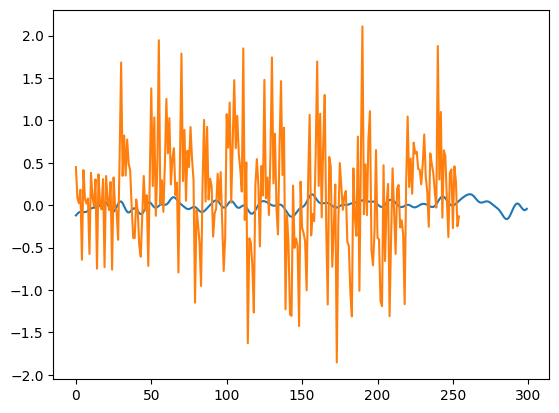

In [156]:
plt.plot(mng_ema_gt[:300, 0])
plt.plot(x[:300, 0].detach().cpu())
scipy.stats.pearsonr(x[:200, 2].detach().cpu(), mng_ema_gt[:200, 2])

In [24]:
def predict_ema(full_input, state=None):
    x = None
    lengths = torch.zeros(full_input.shape[0],) + 50
    lengths = lengths.to(device)
    input_size = segment_length #+ right_context_length
    for i in range(0, full_input.shape[1], segment_length):
        input_ = full_input[:, i:i+input_size, :]
        if input_.shape[1] < input_size:
            input_ = F.pad(input_, (0, 0, 0, input_size - input_.shape[1]))
        x2, lengths, state = emformer.emformer.infer(input_, lengths, state)
        x2 = emformer.output_layer(x2).squeeze(0)
        if x == None:
            x = x2
        else:
            x = torch.cat([x, x2], dim=0)

    x = x.detach().cpu()
    x = torch.tensor(EMADataset.butter_bandpass_filter(x, 10, 50).copy())
    return x, state

In [71]:
test_batch = next(iter(test_dataloader))
test_batch = list(dataset[4])
test_batch[0] = test_batch[0].unsqueeze(0)
test_batch[1] = test_batch[1].unsqueeze(0)
test_ema_gt = test_batch[1].squeeze(0).transpose(1, 2).squeeze(0)
full_input = test_batch[0].squeeze(0).transpose(1, 2)
full_input = full_input.to(device)
print("Full Input:", full_input.shape)

lengths = torch.zeros(full_input.shape[0],) + 50
lengths = lengths.to(device)
print("Lengths:", lengths.shape)

#first_input = full_input[:, :5, :]
#print("First Input:", first_input.shape)
#
#x, lengths, state = emformer.emformer.infer(first_input, lengths)
#x = emformer.output_layer(x).squeeze(0)
#print("First Output:", x.shape)


start = time.time()
x = predict_ema(full_input)[0]
print(time.time() - start)
test_ema_gt = test_ema_gt.detach().cpu()
test_ema_gt = EMADataset.butter_bandpass_filter(test_ema_gt, 10, 50)

Full Input: torch.Size([1, 379, 512])
Lengths: torch.Size([1])
[0.02193962 0.1096981  0.21939621 0.21939621 0.1096981  0.02193962] [ 1.         -0.98532524  0.97384933 -0.38635656  0.11116384 -0.01126351]
1.9550187587738037
[0.02193962 0.1096981  0.21939621 0.21939621 0.1096981  0.02193962] [ 1.         -0.98532524  0.97384933 -0.38635656  0.11116384 -0.01126351]


PearsonRResult(statistic=-0.013053927216992778, pvalue=0.8160628275012783)

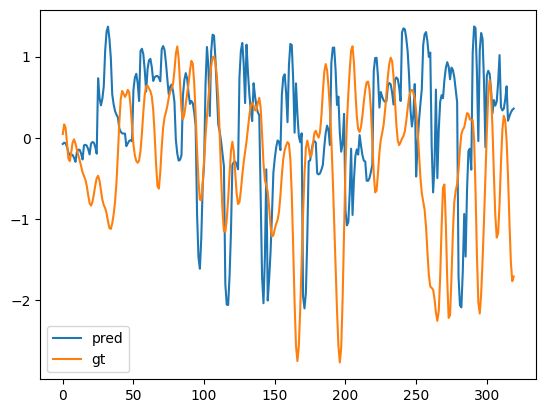

In [121]:
feat_num = 11
plot_len = min(x.shape[0], test_ema_gt.shape[0])
plt.plot(x[:plot_len, feat_num], label="pred")
plt.plot(test_ema_gt[:plot_len, feat_num], label="gt")
plt.legend()
scipy.stats.pearsonr(x[:plot_len, feat_num], test_ema_gt[:plot_len, feat_num])

Text(0.5, 0.98, 'Emformer vs MNGU0 Ground Truth Correlations, Avg: 0.788')

<Figure size 640x480 with 0 Axes>

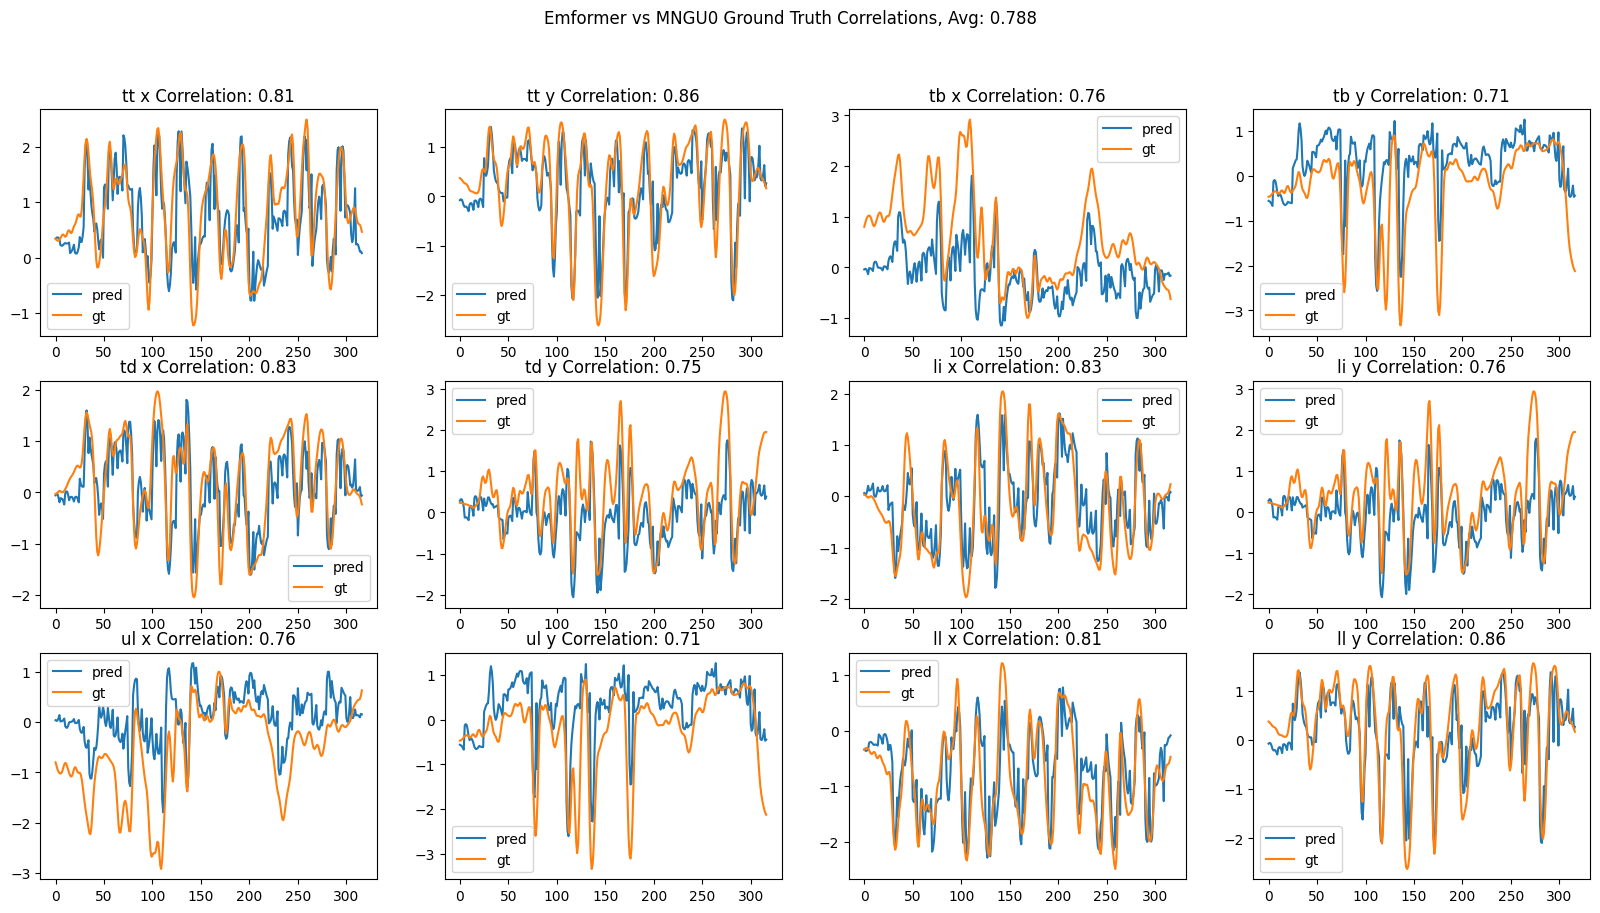

In [117]:
#x = predict_ema(mng_08_feat)
x = pred

plt.tight_layout()
fig, axs = plt.subplots(3, 4, figsize=(20, 10))
parts = ["tt", "tb", "td", "li", "ul", "ll"]
feat_num = 0
corrs = []
for row in range(3):
    for col in range(4):
        plot_len = min(x.shape[0], mng_ema_gt.shape[0])
        axs[row][col].plot(x[:plot_len, feat_num], label="pred")
        axs[row][col].plot(mng_ema_gt[:plot_len, feat_num], label="gt")
        axs[row][col].legend()
        corr = scipy.stats.pearsonr(x[:plot_len, feat_num], mng_ema_gt[:plot_len, feat_num])
        corrs.append(corr[0])
        part = parts[feat_num // 2]
        xy = "x" if feat_num % 2 == 0 else "y"
        axs[row][col].title.set_text(f"{part} {xy} Correlation: {round(corr[0], 2)}")
        feat_num += 1
fig.suptitle(f"Emformer vs MNGU0 Ground Truth Correlations, Avg: {round(np.mean(corrs), 3)}")

In [24]:
dataset.wav_files[:10]

[PosixPath('/data/all_data/VCTK/p225/wav_16/p225_001_mic1.wav'),
 PosixPath('/data/all_data/VCTK/p225/wav_16/p225_001_mic2.wav'),
 PosixPath('/data/all_data/VCTK/p225/wav_16/p225_002_mic1.wav'),
 PosixPath('/data/all_data/VCTK/p225/wav_16/p225_002_mic2.wav'),
 PosixPath('/data/all_data/VCTK/p225/wav_16/p225_003_mic1.wav'),
 PosixPath('/data/all_data/VCTK/p225/wav_16/p225_003_mic2.wav'),
 PosixPath('/data/all_data/VCTK/p225/wav_16/p225_004_mic1.wav'),
 PosixPath('/data/all_data/VCTK/p225/wav_16/p225_004_mic2.wav'),
 PosixPath('/data/all_data/VCTK/p225/wav_16/p225_005_mic1.wav'),
 PosixPath('/data/all_data/VCTK/p225/wav_16/p225_005_mic2.wav')]

In [16]:
full_input = mng_08_feat.transpose(1, 2).to(device)
print(full_input.shape)
x = predict_ema(full_input)

torch.Size([1, 512, 317])


ValueError: Per configured segment_length and right_context_length, expected size of 5 for dimension 1 of input, but got 6.

In [66]:
np.save("../hifigan/ema/mng_08_en.npy", x)

In [57]:
def eval_enformer():
    corrs = []
    for i in tqdm(range(10)):
        test_batch = next(iter(test_dataloader))
        test_ema_gt = test_batch[1].squeeze(0).transpose(1, 2).squeeze(0)
        full_input = test_batch[0].squeeze(0).transpose(1, 2)
        full_input = full_input.to(device)

        lengths = torch.zeros(full_input.shape[0],) + 50
        lengths = lengths.to(device)

        x = predict_ema(full_input)[0]
        test_ema_gt = test_ema_gt.detach().cpu()
        test_ema_gt = EMADataset.butter_bandpass_filter(test_ema_gt, 10, 50)

        plot_len = min(x.shape[0], test_ema_gt.shape[0])
        sample_corrs = []
        for i in range(12):
            sample_corrs.append(scipy.stats.pearsonr(x[:plot_len, i], test_ema_gt[:plot_len, i])[0])
        #print(sample_corrs)
        corrs.append(np.mean(sample_corrs))
    return np.mean(corrs)

In [68]:
eval_enformer()

 10%|█         | 1/10 [00:00<00:07,  1.17it/s]

[0.02193962 0.1096981  0.21939621 0.21939621 0.1096981  0.02193962] [ 1.         -0.98532524  0.97384933 -0.38635656  0.11116384 -0.01126351]
[0.02193962 0.1096981  0.21939621 0.21939621 0.1096981  0.02193962] [ 1.         -0.98532524  0.97384933 -0.38635656  0.11116384 -0.01126351]


 20%|██        | 2/10 [00:01<00:05,  1.43it/s]

[0.02193962 0.1096981  0.21939621 0.21939621 0.1096981  0.02193962] [ 1.         -0.98532524  0.97384933 -0.38635656  0.11116384 -0.01126351]
[0.02193962 0.1096981  0.21939621 0.21939621 0.1096981  0.02193962] [ 1.         -0.98532524  0.97384933 -0.38635656  0.11116384 -0.01126351]


 30%|███       | 3/10 [00:02<00:05,  1.22it/s]

[0.02193962 0.1096981  0.21939621 0.21939621 0.1096981  0.02193962] [ 1.         -0.98532524  0.97384933 -0.38635656  0.11116384 -0.01126351]
[0.02193962 0.1096981  0.21939621 0.21939621 0.1096981  0.02193962] [ 1.         -0.98532524  0.97384933 -0.38635656  0.11116384 -0.01126351]


 40%|████      | 4/10 [00:03<00:05,  1.19it/s]

[0.02193962 0.1096981  0.21939621 0.21939621 0.1096981  0.02193962] [ 1.         -0.98532524  0.97384933 -0.38635656  0.11116384 -0.01126351]
[0.02193962 0.1096981  0.21939621 0.21939621 0.1096981  0.02193962] [ 1.         -0.98532524  0.97384933 -0.38635656  0.11116384 -0.01126351]


 50%|█████     | 5/10 [00:04<00:04,  1.21it/s]

[0.02193962 0.1096981  0.21939621 0.21939621 0.1096981  0.02193962] [ 1.         -0.98532524  0.97384933 -0.38635656  0.11116384 -0.01126351]
[0.02193962 0.1096981  0.21939621 0.21939621 0.1096981  0.02193962] [ 1.         -0.98532524  0.97384933 -0.38635656  0.11116384 -0.01126351]


 60%|██████    | 6/10 [00:05<00:03,  1.02it/s]

[0.02193962 0.1096981  0.21939621 0.21939621 0.1096981  0.02193962] [ 1.         -0.98532524  0.97384933 -0.38635656  0.11116384 -0.01126351]
[0.02193962 0.1096981  0.21939621 0.21939621 0.1096981  0.02193962] [ 1.         -0.98532524  0.97384933 -0.38635656  0.11116384 -0.01126351]


 70%|███████   | 7/10 [00:06<00:03,  1.01s/it]

[0.02193962 0.1096981  0.21939621 0.21939621 0.1096981  0.02193962] [ 1.         -0.98532524  0.97384933 -0.38635656  0.11116384 -0.01126351]
[0.02193962 0.1096981  0.21939621 0.21939621 0.1096981  0.02193962] [ 1.         -0.98532524  0.97384933 -0.38635656  0.11116384 -0.01126351]


 80%|████████  | 8/10 [00:07<00:02,  1.00s/it]

[0.02193962 0.1096981  0.21939621 0.21939621 0.1096981  0.02193962] [ 1.         -0.98532524  0.97384933 -0.38635656  0.11116384 -0.01126351]
[0.02193962 0.1096981  0.21939621 0.21939621 0.1096981  0.02193962] [ 1.         -0.98532524  0.97384933 -0.38635656  0.11116384 -0.01126351]


 90%|█████████ | 9/10 [00:08<00:00,  1.14it/s]

[0.02193962 0.1096981  0.21939621 0.21939621 0.1096981  0.02193962] [ 1.         -0.98532524  0.97384933 -0.38635656  0.11116384 -0.01126351]
[0.02193962 0.1096981  0.21939621 0.21939621 0.1096981  0.02193962] [ 1.         -0.98532524  0.97384933 -0.38635656  0.11116384 -0.01126351]


100%|██████████| 10/10 [00:09<00:00,  1.08it/s]

[0.02193962 0.1096981  0.21939621 0.21939621 0.1096981  0.02193962] [ 1.         -0.98532524  0.97384933 -0.38635656  0.11116384 -0.01126351]
[0.02193962 0.1096981  0.21939621 0.21939621 0.1096981  0.02193962] [ 1.         -0.98532524  0.97384933 -0.38635656  0.11116384 -0.01126351]


0.8837923717226974

In [151]:
def predict_audio(file, forward=0):
    audio, sr = torchaudio.load(file)
    if audio.shape[0] > 1:
        audio = audio[0].unsqueeze(0)
    audio = torchaudio.functional.resample(
        audio, orig_freq=sr, new_freq=16000
    )
    audio = audio.to(device)
    print(audio.shape)
    audio = torch.cat([audio[:, -80:], audio], dim=1)
    print(audio.shape)
    print(feature_model(audio).shape)
    feats = []
    state = None
    for i in range(0, audio.shape[1], 1600):
        curr_audio = audio[:, i:i+1600+forward]
        feat = feature_model(curr_audio)
        feat = feat.transpose(1, 2)
        #print(feat.shape)
        #feat = feat[:, -5:, :]
        #print(feat.shape)
        ema, state = predict_ema(feat, state)
        #print(state[0][1].mean())
        #print(ema.shape)
        feats.append(ema[:5, :])
    feat = torch.cat(feats, dim=0)
    print(feat.shape)
    return feat
    #return predict_ema(feat)

#def predict_audio(file):
#    audio, sr = torchaudio.load(file)
#    if audio.shape[0] > 1:
#        audio = audio[0].unsqueeze(0)
#    audio = torchaudio.functional.resample(
#        audio, orig_freq=sr, new_freq=16000
#    )
#    audio = audio.to(device)
#    feat = feature_model(audio)
#    feat = feat.transpose(1, 2)
#    return predict_ema(feat)

In [146]:
pred = predict_audio("../../inversion/wav/mngu0_s1_0008.wav")

torch.Size([1, 101702])
torch.Size([1, 101782])
torch.Size([1, 512, 317])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1,

torch.Size([1, 101702])
torch.Size([1, 101782])
torch.Size([1, 512, 317])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1, 4, 512])
torch.Size([1,

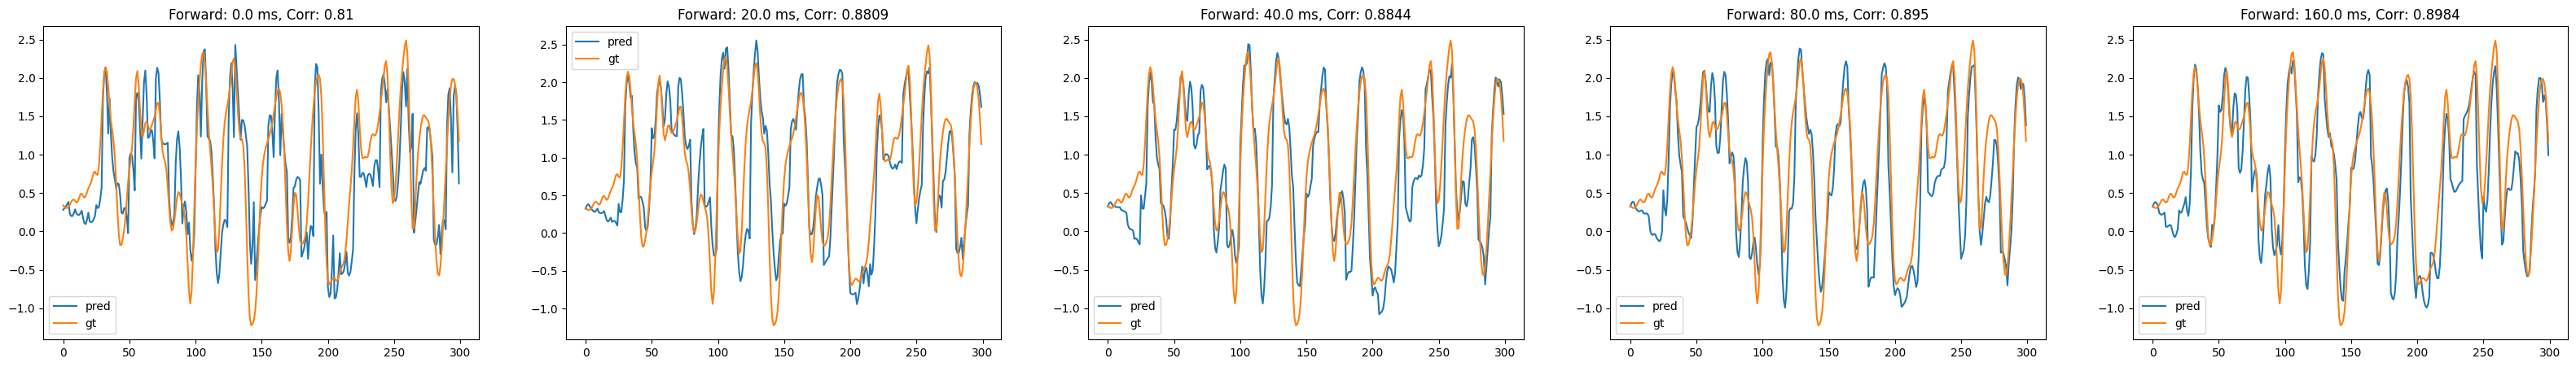

In [150]:
fig, axs = plt.subplots(1, 5, figsize=(40, 5))
preds = []
forwards = [0, 320, 640, 1280, 2560]
for i in range(5):
    preds.append(predict_audio("../../inversion/wav/mngu0_s1_0008.wav", forward=forwards[i]))
    axs[i].plot(preds[i][:300, 0], label="pred")
    axs[i].plot(mng_ema_gt[:300, 0], label="gt")
    plot_len = min(preds[i].shape[0], mng_ema_gt.shape[0])
    corr = scipy.stats.pearsonr(preds[i][:plot_len, 0], mng_ema_gt[:plot_len, 0])
    axs[i].set_title(f"Forward: {forwards[i] / 16000 * 1000} ms, Corr: {round(corr[0], 4)}")
    axs[i].legend()
#np.save("../hifigan/ema/mlk_en.npy", pred)

In [120]:
torch.count_nonzero(preds[0] == preds[1])

tensor(3840)

In [109]:
#pred = pred[0]

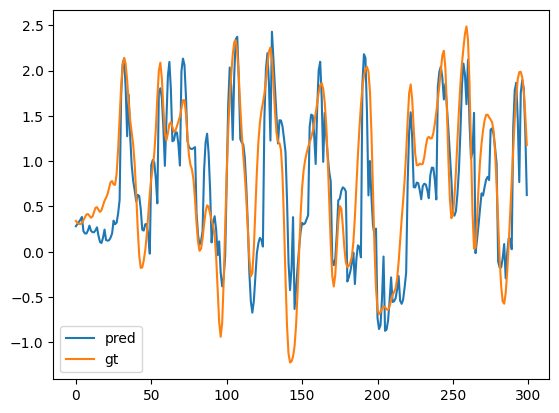

In [147]:
plt.plot(pred[:300, 0], label="pred")
plt.plot(mng_ema_gt[:300, 0], label="gt")
plt.legend()

0.6678538625916364

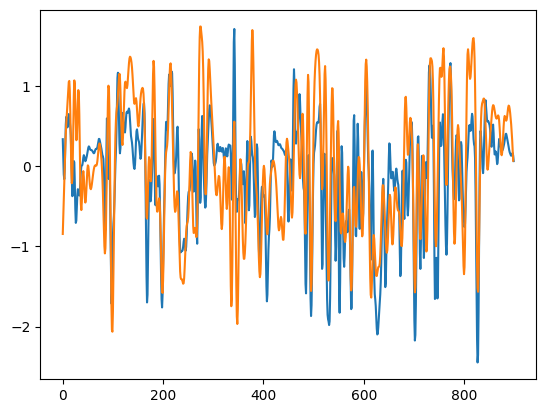

In [98]:
spanish_gt = np.load("../../inversion/ema/spanish_pred.npy")
mngu0_to_hprc(spanish_gt)
feat_num = 7
plt.plot(spanish_pred[:, feat_num])
plt.plot(spanish_gt[:, feat_num])

plot_len = min(spanish_pred.shape[0], spanish_gt.shape[0])
scipy.stats.pearsonr(spanish_pred[:plot_len, feat_num], spanish_gt[:plot_len, feat_num])[0]